# Stock Price Prediction 

In [2]:
import numpy as np
import pandas as pd

In [3]:
file_path = r"C:\Users\KIIT\Downloads\AD LAB\lab3\NFLX.csv"
data = pd.read_csv(file_path)

In [4]:
data = data[['Date', 'Close']]  # Select only Date and Close columns
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data

,Close
Date,
2018-02-05,254.259995
2018-02-06,265.720001
2018-02-07,264.559998
2018-02-08,250.100006
2018-02-09,249.470001
...,...
2022-01-31,427.140015
2022-02-01,457.130005
2022-02-02,429.480011


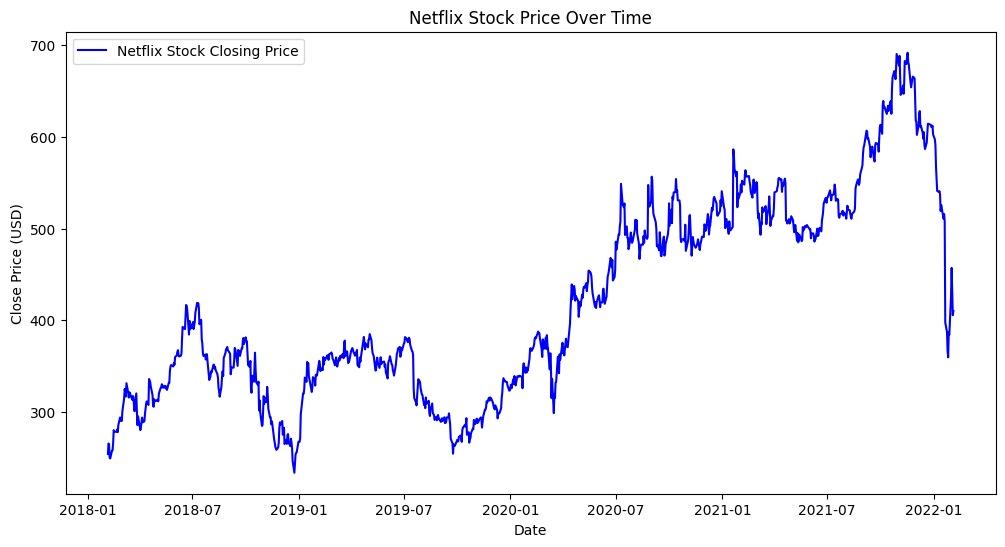

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Netflix Stock Closing Price', color='blue')
plt.title('Netflix Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show() 

### Why MinMaxScaler Is Preferred for Stock Prices
-Stock Prices Are Not Gaussian Distributed:

--StandardScaler assumes the data is normally distributed (bell-shaped curve). However, stock prices often exhibit non-Gaussian distributions due to market fluctuations, trends, and other anomalies.
Applying StandardScaler to non-Gaussian data can lead to skewed results.
Time Series Models (e.g., LSTM) Are Sensitive to Scale:

--LSTM models work better when input features are in a consistent and bounded range, such as [0, 1].
StandardScaler does not guarantee a bounded range, and scaled values might exceed the range of the activation functions used in the model (e.g., sigmoid or tanh).
Preservation of Data Shape:

--MinMaxScaler preserves the original shape and trends of the data, which is crucial for time-series prediction. Stock prices exhibit relative changes and patterns that must remain intact for accurate modeling.
StandardScaler alters the distribution by centering data around the mean, potentially distorting the patterns.

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

In [8]:
scaled_data

array([[0.04451626],
       [0.06954849],
       [0.06701469],
       ...,
       [0.4272515 ],
       [0.37509011],
       [0.38507243]])

In [9]:
import joblib 

In [10]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## When Can train_test_split Be Used?
When Data Is Stationary and Uncorrelated:

If the time-series data is stationary and has no autocorrelation, train_test_split might yield reasonable results. However, most financial time-series data (e.g., stock prices) are non-stationary.
Feature Engineering with Lagged Variables:

After creating lagged features, the dataset can sometimes behave like standard supervised learning data. In such cases, random splits might be acceptable.
When Forecasting Is Not the Goal:

If the task is classification or regression on static features derived from the time-series (e.g., predicting stock direction based on lagged indicators), train_test_split might work.

In [11]:
## 5. Create Sequences for Training and Testing
def create_sequence(data, sequence_length):
    X , y = [] , []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i,0])
        y.append(data[i,0])
    return np.array(X), np.array(y)

In [12]:
sequence_length = 60
X, y = create_sequence(scaled_data,  sequence_length)

#### Key Points:
-> sequence_length: Number of previous time steps used to predict the next time step.

-> X: Contains sequences of the past sequence_length values.

-> y: Contains the target value (the next value after each sequence).

Example: If sequence_length = 3 and data = [1, 2, 3, 4], then X = [[1, 2, 3]] and y = [4].

In [13]:
## 6. Split Data into Training and Testing Sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

reshape(): Flattens the sequences for linear regression, which requires input in a 2D format.

In [14]:
## 7. Prepare Data for Linear Regression
X_train_lr = X_train.reshape(X_train.shape[0], -1)
X_test_lr = X_test.reshape(X_test.shape[0], -1)

In [15]:
## 8. Linear Regression Model
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression.fit(X_train_lr, y_train)

LinearRegression()

In [16]:
lr_pred = linear_regression.predict(X_test_lr)

reshape(): Converts the sequences into a 3D format required by LSTM layers (samples, timesteps, features).

In [17]:
## 9. Prepare Data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [18]:
## 10. LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

c:\Users\KIIT\Downloads\AD LAB\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [20]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train,epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test))

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0554 - val_loss: 0.0162
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0031 - val_loss: 0.0063
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

In [21]:
## 11. Prediction
lstm_predictions = lstm_model.predict(X_test_lstm)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [22]:
lstm_predictions

array([[0.5768147 ],
       [0.58282804],
       [0.56768405],
       [0.5662261 ],
       [0.556679  ],
       [0.55275184],
       [0.56030697],
       [0.5610507 ],
       [0.5565225 ],
       [0.55463403],
       [0.57074034],
       [0.577194  ],
       [0.5834742 ],
       [0.5837244 ],
       [0.5832328 ],
       [0.5843631 ],
       [0.5839416 ],
       [0.57908183],
       [0.5763276 ],
       [0.56423306],
       [0.563463  ],
       [0.5660182 ],
       [0.56563   ],
       [0.55715764],
       [0.5533011 ],
       [0.5544506 ],
       [0.5694368 ],
       [0.5696235 ],
       [0.5666707 ],
       [0.57122093],
       [0.5775488 ],
       [0.576084  ],
       [0.5875815 ],
       [0.60001117],
       [0.6118175 ],
       [0.6272159 ],
       [0.64131844],
       [0.6471172 ],
       [0.6409434 ],
       [0.641873  ],
       [0.6445706 ],
       [0.6558964 ],
       [0.6562295 ],
       [0.648042  ],
       [0.64916676],
       [0.65369165],
       [0.66090184],
       [0.673

In [23]:
## 12. Reverse Scaling
lr_pred = scaler.inverse_transform(lr_pred.reshape(-1, 1))
lstm_predictions = scaler.inverse_transform(lstm_predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

inverse_transform: Converts scaled predictions and targets back to their original scale for evaluation and visualization.

In [24]:
## 13. Evaluate Models
lr_rmse = np.sqrt(mean_squared_error(actual_prices, lr_pred))
lstm_rmse = np.sqrt(mean_squared_error(actual_prices, lstm_predictions))

lstm_r2=r2_score(actual_prices, lstm_predictions)
lr_r2=r2_score(actual_prices, lr_pred)

mean_squared_error: Calculates the mean squared error.

np.sqrt: Computes the root mean squared error (RMSE) for easier interpretation.

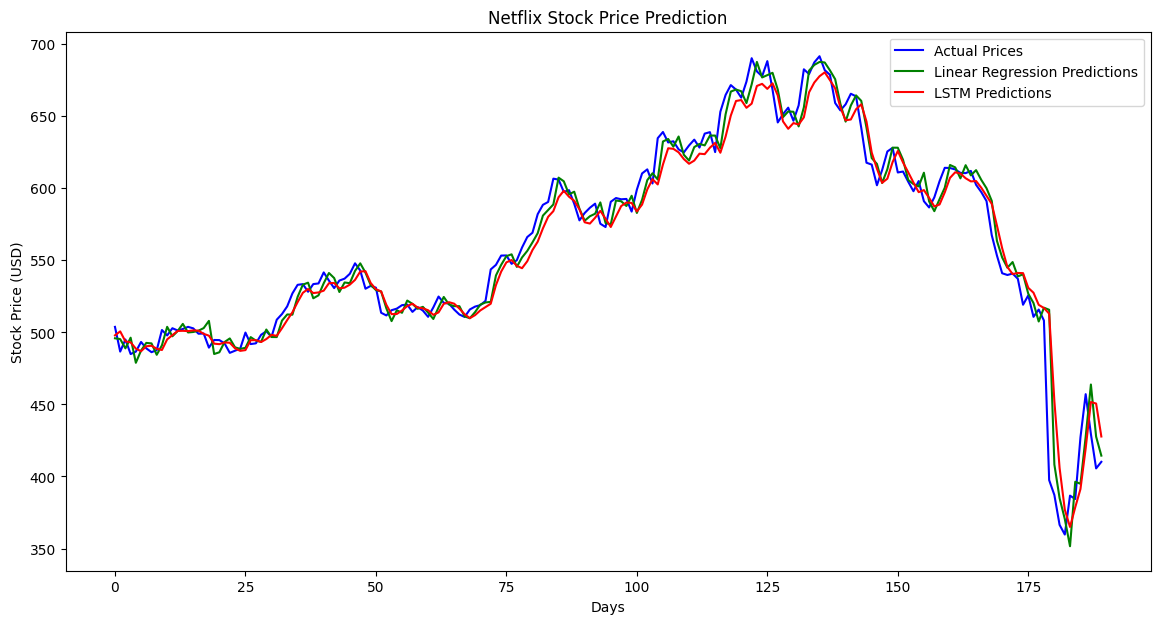

In [25]:
## 14. Visualize Results
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(lr_pred, label='Linear Regression Predictions', color='green')
plt.plot(lstm_predictions, label='LSTM Predictions', color='red')
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [26]:
import joblib

# Save the Linear Regression model
joblib.dump(linear_regression, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [27]:
# Save the LSTM model
lstm_model.save('lstm_model.h5')

In [32]:
# TODO: printing mse and r2 score
print("Root mean square for lstm model: ",lstm_rmse)
print("Root mean square for Linear Regression model: ",lr_rmse)
print("R2 Score for lstm model: ",lstm_r2)
print("R2 Score for linear model: ",lr_r2)

Root mean square for lstm model:  15.88327892028459
Root mean square for Linear Regression model:  13.716819111622595
R2 Score for lstm model:  0.9504148622072697
R2 Score for linear model:  0.9630190534915712
